# Introduction

### Overview:
Using 120k news titles and 4 categories from the AG News set, a model is created to predict the news category given a news title.

Utilized Keras to generate a Convolutional Neural Network (CNN) and baseline dense neural network with a 200 dimensional Genism Glove embedding. Predicted news category with a 87% test set accuracy.

### SetUp:
1. Install all packages from the Import statement.
2. The 200 dimensional Word2Vec file of glove.6B.200d.txt can be downloaded at a zip file [here](http://nlp.stanford.edu/data/glove.6B.zip) (822 MB). See main page at the [GloVe: Global Vectors for Word Representation](https://nlp.stanford.edu/projects/glove/) introduction page.
3. Designate the file path of the input data and Glove embedding file as a string in the 'directory' object.
4. Download data file from the PyTorchNLPBook github [here](https://github.com/joosthub/PyTorchNLPBook/tree/master/data)

### Sources:
1. [Word Embedding use in Keras](https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/)

2. [Original AG News Set](http://www.di.unipi.it/~gulli/AG_corpus_of_news_articles.html)

3. [Convolutional Neural Networks in Keras](https://realpython.com/python-keras-text-classification/#convolutional-neural-networks-cnn)

### Author:
[Aaron Moskowitz](https://www.linkedin.com/in/aaroncmoskowitz/)

# Import

In [1]:
# Directory Configuration
import os

# Goolge Colab Setup
from google.colab import drive

# Object Manipulation
import numpy as np
import pandas as pd

# Word2Vec Import
import gensim
from gensim.test.utils import datapath

# Tokenizer
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

# Embedding Creation
from numpy import asarray
from numpy import zeros

# Keras
from keras import layers
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Activation, Dense, Embedding, Flatten
from keras.callbacks import EarlyStopping

# Test Train Split
from sklearn.model_selection import train_test_split

# Visulization
%matplotlib notebook
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

Using TensorFlow backend.


# Setup of project directory, or use of google Colab to run code

In [1]:
#drive.mount('/content/drive')

In [0]:
directory = "/content/drive/My Drive/Colab Notebooks/Deep_Learning_NLP/Keras_News_Classification_NLP_Project"

In [0]:
os.chdir(directory)

In [0]:
glove_size = 200
glove_file = datapath(directory + '/glove/glove.6B.' + str(glove_size) + 'd.txt')

# Load Embedding

### Load the embedding into memory

In [0]:
embeddings_index = dict()

f = open(datapath(glove_file))
for line in f:
    values = line.split()
    word = values[0]
    coefs = asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

### Confirm Gensin embedding is expected

In [7]:
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [8]:
print('''Confirm the embedding of a relevant word such as 'washington' with its embedding size of''', len(embeddings_index['washington']), 'is expected.')
print('View first 5 ellements of the embedding to see if it is plausible. First ellements are', embeddings_index['head'][0:5])

Confirm the embedding of a relevant word such as 'washington' with its embedding size of 200 is expected.
View first 5 ellements of the embedding to see if it is plausible. First ellements are [-0.26623  -0.75065  -0.031357 -0.03684  -0.1875  ]


# Import Data

In [9]:
# Load data from csv
df = pd.read_csv(directory + '/data/news_with_splits.csv')

df.groupby(['category']).count()

,split,title
category,,
Business,30000,30000
Sci/Tech,30000,30000
Sports,30000,30000
World,30000,30000


In [10]:
col = ['title', 'category']
input_data = df[col]

# Get titles into a series
categories = df['category']
titles = df['title']

print('Data import has rows of:', len(df))

Data import has rows of: 120000


### View 5 example titles and associated categories in data to confirm upload worked as expected

In [12]:
titles.head()

0      Jobs, tax cuts key issues for Bush
1    Jarden Buying Mr. Coffee #39;s Maker
2       Retail sales show festive fervour
3     Intervoice's Customers Come Calling
4       Boeing Expects Air Force Contract
Name: title, dtype: object

In [13]:
categories.head()

0    Business
1    Business
2    Business
3    Business
4    Business
Name: category, dtype: object

# Create One Hot Encoding and Dictionary for Categories

## Create integer dictionary for pompts

In [0]:
# Adding a column of category_id encoding the category as an integer to ease in represenation of class
input_data['category_id'] = categories.factorize()[0]
category_id_df = input_data[['category', 'category_id']].drop_duplicates().sort_values('category_id')

# Generate dictionary to code categorical_id back to category
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'category']].values)

# Creating category of a list of integers
category = list(input_data['category_id'])

### View category_id to category dictionary

In [60]:
print('The size of the dictionary is', len(set(id_to_category)))

print('\nView entire dictionary:', id_to_category)

The size of the dictionary is 4

View entire dictionary: {0: 'Business', 1: 'Sci/Tech', 2: 'Sports', 3: 'World'}


## Create one hot encoding representation of category

In [61]:
category[0:5]

[0, 0, 0, 0, 0]

In [62]:
category_length = len(np.array(category))
class_len = len(set(category))
print('Confirm category length is unchanged:', class_len)

Confirm category length is unchanged: 4


In [0]:
category_length = len(np.array(category))

empty_array = np.zeros((category_length, class_len))
empty_array[np.arange(category_length), category] = 1
category_one_hot = empty_array

In [64]:
#View sample of one hot encoding
category_one_hot

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

In [65]:
print('Confirm that all records are covered in one hot encoding:', len(category_one_hot))

Confirm that all records are covered in one hot encoding: 120000


# Prepare data features

In [66]:
# Lowercase
titles_clean = titles.apply(lambda x: x.lower())
titles_clean = titles

titles_clean.head()

0      Jobs, tax cuts key issues for Bush
1    Jarden Buying Mr. Coffee #39;s Maker
2       Retail sales show festive fervour
3     Intervoice's Customers Come Calling
4       Boeing Expects Air Force Contract
Name: title, dtype: object

In [67]:
# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(titles_clean.tolist())
vocab_size = len(t.word_index) + 1

# integer encode the documents
encoded_docs = t.texts_to_sequences(titles.tolist())
print(encoded_docs[0:5])

[[120, 327, 119, 353, 697, 4, 48], [10508, 1397, 3376, 3671, 3, 7, 978], [601, 56, 362, 10509, 17583], [22587, 1268, 1154, 2512], [536, 1276, 201, 528, 443]]


In [69]:
print('The training data title vocabulary size is', vocab_size)

The training data title vocabulary size is 36758


In [70]:
# pad documents to a max length of the longest title
max_length = 0
for doc in encoded_docs:
  if len(doc) > max_length:
    max_length = len(doc)

print('The training data with the longest word length is', max_length)

padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

The training data with the longest word length is 24


In [71]:
print('Confirm that the padded_docs has the correct size of', len(padded_docs))

Confirm that the padded_docs has the correct size of 120000


In [75]:
print('Confirm that the title below has the same number of non zero tokens in the padded document of:', titles[0])

Confirm that the title below has the same number of non zero tokens in the padded document of: Jobs, tax cuts key issues for Bush


In [76]:
print('See padded document for the position 1 title', padded_docs[0])

See padded document for the position 1 title [120 327 119 353 697   4  48   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0]


### Add an index in front of each padded title to allow tracking of the true category

In [77]:
indexed_padded_docs = list()

counter = 0
for row in padded_docs:
  indexed_padded_docs.append(list((counter, row)))
  counter = counter + 1

indexed_padded_docs = np.array(indexed_padded_docs)

print(type(indexed_padded_docs))
print(len(indexed_padded_docs))
print(indexed_padded_docs[0:4])

<class 'numpy.ndarray'>
120000
[[0
  array([120, 327, 119, 353, 697,   4,  48,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)]
 [1
  array([10508,  1397,  3376,  3671,     3,     7,   978,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0], dtype=int32)]
 [2
  array([  601,    56,   362, 10509, 17583,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0], dtype=int32)]
 [3
  array([22587,  1268,  1154,  2512,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0], dtype=int32)]]


In [79]:
# Confirm length of padded docs is correct
len(padded_docs)

120000

# Prepare Weights for Data from Embedding

In [0]:
# create a weight matrix for words in training docs
embedding_matrix = zeros((vocab_size, glove_size))
for word, i in t.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

In [81]:
# View embedding matrix
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.57345998,  0.54170001, -0.23477   , ...,  0.54417998,
        -0.23069   ,  0.34946999],
       [-0.10272   ,  0.30410001, -0.13576999, ...,  0.36950999,
         0.19039001, -0.12266   ],
       ...,
       [ 0.25883999, -0.67852998,  0.058128  , ...,  0.64424998,
         0.58279997,  0.38321   ],
       [ 0.19574   , -0.50405997, -0.13177   , ...,  0.15817   ,
         0.51892   , -0.12782   ],
       [ 0.31279999,  0.11203   ,  0.33820999, ..., -0.12418   ,
        -0.035783  , -0.46472999]])

In [82]:
type(embedding_matrix)

numpy.ndarray

In [89]:
print('Confirm vocabulary size is rows of ' + str(vocab_size) + ' and embedding size of ' + str(glove_size) + ' is number of columns')
np.shape(embedding_matrix)

Confirm vocabulary size is rows of 36758 and embedding size of 200 is number of columns


(36758, 200)

# Test Train Split

In [0]:
#split the data into training, validation, and test set with 80%, 10%, 10% respectively
train_x, test_x, train_y, test_y = train_test_split(indexed_padded_docs ,category_one_hot, test_size=0.1, random_state=1,shuffle=True)

train_x, val_x, train_y, val_y = train_test_split(train_x ,train_y, test_size=0.1111111, random_state=2, shuffle=True)

### Confirm that sizes of features and target in both the train and test are the same, and view sample of train set.

In [91]:
print(len(train_x))
print(len(train_y))
print(len(val_x))
print(len(val_y))
print(len(test_x))
print(len(test_y))

96000
96000
12000
12000
12000
12000


In [92]:
train_x[0:5]

array([[108099,
        array([ 9632,  3163,  6371,     4, 14471,  1777,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0], dtype=int32)],
       [118739,
        array([  373, 11438,   147,   311,     4,    65,  3118,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0], dtype=int32)],
       [91242,
        array([  48, 2864, 4001,    4,  461,  312,  316,  285,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0], dtype=int32)],
       [87803,
        array([ 725,  503,  238,   50, 1143, 4148,  112,    8,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0], dtype=int32)],
       [89778,
        array([1346, 1456, 3941,  741,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,  

### Create helper function to convert indexed array to non-indexed array for use in training

In [93]:
def to_non_indexed_array(indexed_array):
   
  non_indexed_list = list()

  counter = 0
  for row in indexed_array:

    non_indexed_list.append(row[1])
    counter = counter + 1

  non_indexed_array = np.array(non_indexed_list)
  
  return(non_indexed_array)

to_non_indexed_array(test_x)

array([[  641,  1240,  2411, ...,     0,     0,     0],
       [ 3524,     2,   617, ...,     0,     0,     0],
       [ 1398,   455,   132, ...,     0,     0,     0],
       ...,
       [  554,  6920,   119, ...,     0,     0,     0],
       [  360,     3,     7, ...,     0,     0,     0],
       [18101,  7595,     4, ...,     0,     0,     0]], dtype=int32)

# Create Dense Neural Network

In [95]:
# Define model
model_dense = Sequential()

# Embedding Layers
e = Embedding(vocab_size, glove_size, weights=[embedding_matrix], input_length=max_length, trainable=False)
model_dense.add(e)
model_dense.add(Flatten())

# Dense layer
model_dense.add(Dense(len(set(category))))

# Output Layer
model_dense.add(Activation('softmax'))

# Compile Model
model_dense.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Summarize Model
model_dense.summary()

# Early Stopping
es = EarlyStopping(monitor='val_acc', mode='max', patience = 1)

# Fit Model
history_dense = model_dense.fit(to_non_indexed_array(train_x), train_y,
                                epochs=20,
                                verbose=1,
                                validation_data=(to_non_indexed_array(val_x), val_y),
                                callbacks=[es]
                               )

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 24, 200)           7351600   
_________________________________________________________________
flatten_2 (Flatten)          (None, 4800)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 19204     
_________________________________________________________________
activation_2 (Activation)    (None, 4)                 0         
Total params: 7,370,804
Trainable params: 19,204
Non-trainable params: 7,351,600
_________________________________________________________________
Train on 96000 samples, validate on 12000 samples
Epoch 1/20
96000/96000 [==============================] - 13s 135us/step - loss: 0.5087 - acc: 0.8230 - val_loss: 0.4681 - val_acc: 0.8367
Epoch 2/20
96000/96000 [========================

# Create Convolutional Neural Network

In [96]:
cnn_model = Sequential()

# Embedding Layer
e = Embedding(vocab_size, glove_size, weights=[embedding_matrix], input_length=max_length, trainable=False)
cnn_model.add(e)

# Convolutional and Max Pooling Layer
cnn_model.add(layers.Conv1D(128, 3, activation='relu'))
cnn_model.add(layers.GlobalMaxPooling1D())

# Dense Layers
cnn_model.add(layers.Dense(10, activation='relu'))

cnn_model.add(layers.Dense(10, activation='relu'))

# Output Layer
cnn_model.add(layers.Dense(len(set(category)), activation='sigmoid'))
cnn_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

# Summarize Model
cnn_model.summary()

# Early Stopping
es = EarlyStopping(monitor='val_categorical_accuracy', mode='max', patience = 1)

# Fit Model
history = cnn_model.fit(to_non_indexed_array(train_x),train_y,
                    epochs=2,
                    verbose=1,
                       validation_data=(to_non_indexed_array(val_x), val_y)
                        ,callbacks=[es]
                       )

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 24, 200)           7351600   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 22, 128)           76928     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_7 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 44        
Total params: 7,429,972
Trainable params: 78,372
Non-trainable params: 7,351,600
_______________________________________

# Evaluate Model

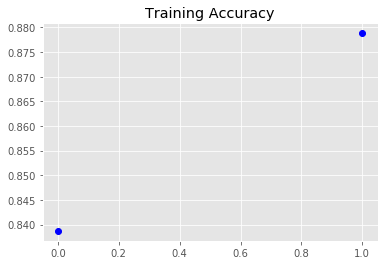

In [108]:
loss = history.history['categorical_accuracy']

#Number of Epochs
epochs = range(len(loss))

plt.figure()

# Plot Training Accuracy
plt.plot(epochs, loss, 'bo', label='Training Accuracy')
plt.title('Training Accuracy')
plt.show()

In [110]:
# evaluate the model on validation set
loss, accuracy = cnn_model.evaluate(to_non_indexed_array(val_x), val_y, verbose=0)
print('Accuracy in the validation set is %f' % (accuracy*100))

Accuracy in the validation set is 87.325000


# Exploration of Output

In [0]:
def exploration_output(model_exploration, num, verbose = True):
  '''Parameters: model_exploration - type: keras.engine.sequential.Sequential
    num - type: integer - Element in the validation set to view the actual class and scores of predicted classes
    verbose - type: boolean - If True, prints details out title of the num element in the test set, and the true class of the element.
    Output: Descending dataframe of most probable classes ordered by softmax scoring
  '''
  if verbose:
    print('Testing output from title of:', titles[val_x[num][0]])

  model_exploration.predict(to_non_indexed_array(val_x), verbose=0)[num]

  results = pd.DataFrame(columns=['Class Id', 'Category', 'Score'])
  results = list()
  index = 0
  for score in model_exploration.predict(to_non_indexed_array(val_x), verbose=0)[num]:
    row = list((index, id_to_category.get(index), score))
    results.append(row)
    index = index + 1

  results = pd.DataFrame(columns=['Class Id', 'Category', 'Score'], data = results)
  
  if verbose:
    print('True class is:', id_to_category.get(np.argmax(val_y[num])))
    
  return(results.sort_values(by='Score', ascending = False).head())

### Easy Validation Set Examples

In [112]:
exploration_output(model_dense, 5)

Testing output from title of: Sadr Militia in Contacts to Hand Over Najaf Shrine
True class is: World


,Class Id,Category,Score
3,3,World,0.999184
2,2,Sports,0.000750
1,1,Sci/Tech,0.000055
0,0,Business,0.000012


In [113]:
exploration_output(cnn_model, 5)

Testing output from title of: Sadr Militia in Contacts to Hand Over Najaf Shrine
True class is: World


,Class Id,Category,Score
3,3,World,0.980802
1,1,Sci/Tech,0.000364
0,0,Business,0.000280
2,2,Sports,0.000116


### Hard Validation Set Examples

In [114]:
exploration_output(cnn_model, 200)

Testing output from title of: Update 6: Motorola Expands Cell-Phone Market Niche
True class is: Business


,Class Id,Category,Score
1,1,Sci/Tech,0.657966
0,0,Business,0.208693
3,3,World,0.000111
2,2,Sports,0.000015


The example is subtle when even though Motorola and cell-phones would be common in technology articles, the context of them with words like market or especially the phrase "market niche" clearly indicate that the example is primarily business related. Good sign that there is a softmax score of .20 for business, with only a .66 score for technology. BERT and other transformers to understand how the context of a word like motorola or cell-phone changes in the context of phrases such as "market niche" could possibly correctly categorize this example.

In [115]:
exploration_output(cnn_model, 106)

Testing output from title of: Tag Team: Yahoo and Adobe
True class is: Business


,Class Id,Category,Score
1,1,Sci/Tech,0.453019
0,0,Business,0.070219
2,2,Sports,0.003894
3,3,World,0.000837


Similar to above, the meaning of of words of Yahoo and Adobe shift when they appear together versus when they appear on their own.

# Test Set Accuracy

In [118]:
# evaluate the model on test set
loss, accuracy = cnn_model.evaluate(to_non_indexed_array(test_x), test_y, verbose=0)
print('Accuracy: %f' % (accuracy*100))

Accuracy: 87.266667
